# 1. Import Library

# 資料準備

In [1]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, load_model,Model
from keras.layers.core import Dense, Dropout, Activation,Flatten
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM,GRU
from keras.layers.wrappers import Bidirectional
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding,GRU,Conv1D, MaxPooling1D,GlobalMaxPooling1D,SpatialDropout1D
from keras.utils import np_utils
from datetime import datetime,timedelta

from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.optimizers import adam
import tensorflow.keras as keras
import numpy as np
import requests
import pandas as pd

# import urllib.request
import os
import tarfile
np.random.seed(10)


/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
os.chdir("../")
os.getcwd()

'/project/at081-group3'

In [3]:
#from data_utils import cut_to_word,covert_sequences,get_word2vec_embeddings
#from data_utils import get_average_word2vec,produce_cbowfile,JiebaSegmentor,data_reduction,seperatedata
from data_utils import *
from data_utils import JiebaSegmentor

In [4]:
jieba_dict_path1 = "jieba/dict_taiwan.txt"
jieba_dict_path2 = "jieba/userdict.txt"
jieba_dict_path3 = "jieba/dict.txt.big"
jieba_dict_path4 = "jieba/dict.txt.small"
jieba_stopwords_path = "jieba/stopwords.txt"

js = JiebaSegmentor(dict_path=jieba_dict_path1,
                    userdict=[],
                    stopwords=True,
                    stopwords_path=jieba_stopwords_path)
# js = JiebaSegmentor(jieba_dict_path1, [jieba_dict_path2, jieba_dict_path3, jieba_dict_path4])

In [5]:
test_cut_raw_0 = js.lcut('北京在哪呢', cut_type='df')
# test_cut_raw_0
for x in test_cut_raw_0:
    print (x)

Building prefix dict from /project/at081-group3/jieba/dict_taiwan.txt ...
Loading model from cache /tmp/jieba.u511841703c1a13552c7be402538ee161.cache
Loading model cost 0.540 seconds.
Prefix dict has been built succesfully.


word


In [6]:
test_cut_raw_0 = js.pseg_lcut('打分機給')
test_cut_raw_0

,word,tag
0,分機,n


In [7]:
test_cut_raw_0 = js.lcut('打分機給')
test_cut_raw_0

,word
0,分機


In [8]:
#先讀取所有文章建立字典，限制字典的數量為nb_words=2000

In [9]:
df = pd.read_csv('Project_19999/data/19999_question_category_a_v2.csv')#usecols=['description','category_a', 'category_a_target']

In [10]:
df.head(10)

,description,category_a,category_a_target
0,無法透過 CAMP 上SIT 系統 icon 的連接登入. 可否協助看一下這問題,CAMP,1
1,收到CAMP 簽核表單，開頭CAF_QRDC，不清楚這是什麼簽核表單,CAMP,1
2,"無法會員登入,顯示訊息:無效的帳號或使用者不存在。帳號:96122401",CAMP,1
3,因今天有事請假，要補登先前的加班，但開啟camp後，出勤表單顯示的內容看起來像測試的，沒有最...,CAMP,1
4,四月中時修改中英文姓名，Outlook已生效，但CAMP仍為舊名字。,CAMP,1
5,"手機簽核BPM有問題,都顯示亂碼 #18227",CAMP,1
6,無法在手機上面使用CAMP進行表單簽核動作。分機：17132,CAMP,1
7,CAMP上的會議室預約系統無法使用，煩請幫忙處理 #13931,CAMP,1
8,分機: 17451 問題: 使用雲端會議功能時，無法設定預設群組，造成無法繼續選擇會議室預約,CAMP,1
9,資料不見，沒有顯示表單,CAMP,1


In [11]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38040 entries, 0 to 38039
Data columns (total 3 columns):
description          38040 non-null object
category_a           38040 non-null object
category_a_target    38040 non-null int64
dtypes: int64(1), object(2)
memory usage: 891.6+ KB


In [12]:
df.category_a_target.value_counts()

7    32438
4     2600
0      997
6      706
5      618
3      424
2      142
1      115
Name: category_a_target, dtype: int64

In [13]:
df[df['description'].str.len()<5].category_a_target.value_counts()/df.category_a_target.value_counts()

7    0.040601
4    0.018077
0    0.030090
6    0.018414
5    0.014563
3    0.014151
2    0.021127
1    0.008696
Name: category_a_target, dtype: float64

In [14]:
# index to categories mapping
mapping = df.category_a.astype('category').cat.categories
mapping

Index(['BPM平台系統', 'CAMP', 'GOC', 'R&D資訊系統', 'SAP-168(QCI)', 'SAP-2X8(QSMC)',
       '內部資訊系統', '網管'],
      dtype='object')

In [15]:
df=data_reduction(df)

In [16]:
df.category_a_target.value_counts()

0    967
3    418
Name: category_a_target, dtype: int64

In [17]:
print (cut_to_word('可以幫我聯絡'.strip(),js))
df['cut_words'] = df['description'].apply(lambda s: cut_to_word(s.strip(),js))
df['cut_words'] = df['description'].apply(lambda s: cut_to_word(s.strip(),js))

聯絡


TODO: 拿掉時間,人名

In [18]:
data,word2vec=produce_cbowfile(df.description ,jieba_stopwords_path)
print(data[0:5])


[['MRO', ' ', ' ', '申請', '四筆', '費用', '未稅', '收料', 'PO', '共收', '料四筆', '總金額', '未稅', ' ', ' ', '發票', '作業', '時', '輸入', '發票', '總金額', '後', '系統', '卻', '自動', '計算', '稅額', '元', '出現', '網頁', '訊息', '請款', '稅額', '需', '等於', '驗收', '金額', '加總', 'PO', '稅額', '系統', '計算', ' ', ' ', '麻煩', '幫忙', '一下', '問題'], ['BPM', ' ', 'MRO', '驗收', '問題', '諮詢', '一下', ' ', ' ', 'EXT'], ['訪客', '申請單', '時間', '往後', '改'], ['人', '薪資', '明細單', '無法', '開啟'], ['客戶', '廠商', '無法', '登入', 'Quanta', ' ', 'issue', ' ', 'tracking', ' ', 'system', ' ', ' ', ' ', '帳號', 'tandy', 'jg', 'jgnet', 'com', 'tw', ' ', ' ', ' ', '星期', '還可以', '正常', '登入', '星期一', '無法', '登入', ' ', ' ', ' ', '錯誤', '訊息', ' ', ' ', ' ', '未經', '授權', ' ', '認證', '無效', '拒', '絶', '存取']]


In [19]:
x = df.cut_words
y = df.category_a_target
x_train,x_test,y_train,y_test =seperatedata(x,y)

In [20]:
#le = LabelEncoder()  
#y_test = le.fit_transform(y_test) # 這邊Y.shape = (84020, )
#y_test = y_test.reshape(-1,1) # 將Y的shape轉換成： Y.shape= (84020, 1)

In [21]:
# label 做 onehot
y_one_hot,num_classes = labelEncoding(y_train)

[0. 0. 0. 1.]
num_classes = 4


In [22]:
# label 做 onehot
training_embeddings = get_word2vec_embeddings(word2vec, x_train, generate_missing=True)

In [23]:
word2vec.wv.most_similar(positive=['帳號'], negative=['系統'])

[('重慶', 0.023930462077260017),
 ('Assign', 0.009105905890464783),
 ('異動', 0.004208933562040329),
 ('早上', 0.004124910570681095),
 ('攜出', 0.004015619866549969),
 ('昨天', 0.0038083773106336594),
 ('非', 0.0030888672918081284),
 ('號', 0.0029879193753004074),
 ('借到', 0.002569318749010563),
 ('management', 0.00244279857724905)]

In [24]:
y_test.head(10)

1128    0
237     0
163     0
739     3
51      0
666     0
818     3
67      0
759     3
553     0
Name: category_a_target, dtype: int64

In [25]:
df_test_y=y_test
df_test_x=x_test
df_test_x.head(10)

1128    使用,欲,填寫,申請單,,, ,系統,顯示,查無,資產,編號,,, ,請,協助,處理, ,1...
237     無法,順利,簽核,表單, , ,表單,編號,APP0037596, , ,聯絡,分機,382...
163           欲,填,快遞,寄件,申請單, ,但連,兩天,出現,錯誤,信息,顯示,錯誤,代碼,500
739      ,開, ,下面,畫面, ,2.5,分鐘,左右, , , , ,leo, ,lin, , ,...
51                         放行,頁面,Print,鈕,,,無法,下載,PDF,檔,放行
666                               BPM,系統,打不開, , ,38514491
818     project, ,leader,但確,無法,issue,做,assign,reassign...
67                           請,協助,處理, ,謝謝, , , ,EXT,12633
759           Download, ,test, ,report, ,出現,Data, ,Failed
553                       分機, ,15601, , ,問題, ,請假,頁面,無法,使用
Name: cut_words, dtype: object

In [26]:
# 標點符號過濾
WORD_FILTERS = '!"#$&()*+,-./:;<=>?@[\\]^_{|}~\t\n'
# 字典數量
NUM_WORDS = 1000
# 向量長度
MAX_LEN = 100

embedding_dim=256

x_train2=x_train

x_train,train_word_index = covert_sequences(x_train,NUM_WORDS, MAX_LEN)
x_test,train_word_index = covert_sequences(x_test,NUM_WORDS, MAX_LEN)
x_train2,train_word_index = covert_sequences(x_train2,NUM_WORDS, MAX_LEN)

Found 3473 unique tokens.
Found 1550 unique tokens.
Found 3473 unique tokens.


In [27]:
x_train

array([[  0,   0,   0, ...,   9,  34, 262],
       [  0,   0,   0, ..., 179,  73,   6],
       [  0,   0,   0, ...,   1,   1,  18],
       ...,
       [  0,   0,   0, ...,  56,  96,  16],
       [  0,   0,   0, ..., 241,   1,  54],
       [  0,   0,   0, ...,   2, 803, 122]], dtype=int32)

In [28]:
#train_word_index

In [29]:
train_embedding_weights = np.zeros((len(train_word_index)+1, embedding_dim))

for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(embedding_dim)
print(train_embedding_weights)
print("-----------=====-----------")
print(train_embedding_weights.shape)
# 字典數量
#NUM_WORDS = train_embedding_weights.shape[0]

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.29148731 -0.67630154 -0.41275546 ... -0.20976962 -0.59043521
   0.50394881]
 [-0.1643056  -0.37943158 -0.23069459 ... -0.1161773  -0.32872337
   0.28333536]
 ...
 [ 0.82244248  0.68183111  0.64753193 ...  0.29236743  0.91815528
   0.02375721]
 [ 0.64326667  0.90700839  0.02631449 ...  0.61480324  0.19060096
   0.21486615]
 [ 0.52904488  0.80631871  0.46396875 ...  0.5813795   0.18994779
   0.03935   ]]
-----------=====-----------
(3474, 256)


In [30]:
nb_words = min(NUM_WORDS, len(train_word_index)) # How many words are there actually

embedding_matrix = np.zeros((nb_words, embedding_dim))

# The vectors need to be in the same position as their index. 
# Meaning a word with token 1 needs to be in the second row (rows start with zero) and so on

# Loop over all words in the word index
for word, i in train_word_index.items():
    # If we are above the amount of words we want to use we do nothing
    if i >= NUM_WORDS: 
        continue
    # Get the embedding vector for the word
    embedding_vector = df.cut_words.get(word)
    # If there is an embedding vector, put it in the embedding matrix
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector

In [31]:
embedding_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [32]:
print (x_train)
# x_train

[[  0   0   0 ...   9  34 262]
 [  0   0   0 ... 179  73   6]
 [  0   0   0 ...   1   1  18]
 ...
 [  0   0   0 ...  56  96  16]
 [  0   0   0 ... 241   1  54]
 [  0   0   0 ...   2 803 122]]


In [33]:
print (x_test.shape)
x_test

(347, 100)


array([[  0,   0,   0, ...,  13,   1, 586],
       [  0,   0,   0, ...,  12,  82, 588],
       [  0,   0,   0, ...,   9, 348, 189],
       ...,
       [  0,   0,   0, ...,  13,   1,   1],
       [  0,   0,   0, ...,   1,   2,  59],
       [  0,   0,   0, ...,   2, 118,  63]], dtype=int32)

In [34]:
x_train.shape, y.shape, x_test.shape

((1038, 100), (1385,), (347, 100))

In [35]:
y_one_hot[:5]

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]], dtype=float32)

# 建立模型

In [36]:
print(NUM_WORDS)
print(num_classes)
print(MAX_LEN)

1000
4
100


In [37]:
def build_model(num_classes, vocab_size, sentence_max_len,embedding_dim):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim, 
                        input_length=sentence_max_len))
    model.add(Bidirectional(LSTM(128,implementation=2)))
    model.add(Dropout(0.5))
    #model.add(Flatten())
    model.add(Dense(256,activation='tanh'))
    model.add(Dropout(0.5))
    #model.add(Dense(50,activation='tanh'))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    return model

In [38]:
def build_model2(num_classes, vocab_size, sentence_max_len,embedding_dim):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=sentence_max_len))
    model.add(SpatialDropout1D(0.7))
    model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
    model.add(Dense(50,activation='tanh'))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    return model

In [39]:
# https://www.kaggle.com/qqgeogor/keras-lstm-attention-glove840b-lb-0-043
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
from keras import backend as K
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [40]:
#https://www.kaggle.com/suicaokhoailang/lstm-attention-baseline-0-672-lb
from keras.layers import CuDNNLSTM
def build_model3(num_classes, vocab_size, sentence_max_len,embedding_dim):
    SEQ_LEN = 100  # magic number - length to truncate sequences of words
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim, 
                        #weights=[train_embedding_weights],#需要研究如何用
                        input_length=sentence_max_len))
    model.add(Bidirectional(CuDNNLSTM(64, return_sequences=True)))
    model.add(Bidirectional(CuDNNLSTM(64,return_sequences=True)))
    model.add(Attention(SEQ_LEN))
    model.add(Dropout(0.5))
    #model.add(Flatten())
    model.add(Dense(256,activation='tanh'))
    model.add(Dropout(0.5))
    #model.add(Dense(50,activation='tanh'))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    return model

In [41]:
from keras.layers.merge import concatenate, add
#https://www.kaggle.com/kakiac/deep-learning-4-text-classification-cnn-bi-lstm
def ConvNet(num_classes, vocab_size, max_sequence_length, embedding_dim,trainable=False, extra_conv=True):
    #the filter
    embedding_dim=256
    embedding_layer = Embedding(vocab_size,
                            embedding_dim,
                            weights=[embedding_matrix],#需要研究如何用
                            input_length=max_sequence_length,
                            trainable=trainable)

    #the unknown image
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    #the merge function of the first convolution 
    embedded_sequences = embedding_layer(sequence_input)

    # Yoon Kim model (https://arxiv.org/abs/1408.5882)
    convs = []
    filter_sizes = [3,4,5] # in the loop, first apply 3 as size, then 4 then 5

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
        #kernel is the filter
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convs.append(l_pool)

    l_merge = concatenate(convs, axis=1)

    
    # activated if extra_convoluted is true at the def
    # add a 1D convnet with global maxpooling, instead of Yoon Kim model
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pool = MaxPooling1D(pool_size=3)(conv)

    if extra_conv==True:
        x = Dropout(0.5)(l_merge)  
    else:
        # Original Yoon Kim model
        x = Dropout(0.5)(pool)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    # Finally, we feed the output into a Sigmoid layer.
    # The reason why sigmoid is used is because we are trying to achieve a binary classification(1,0) 
    # for each of the 6 labels, and the sigmoid function will squash the output between the bounds of 0 and 1.
    preds = Dense(num_classes, activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.summary()
    return model

In [42]:
#https://www.kaggle.com/ngyptr/multi-class-classification-with-lstm

In [43]:
#https://www.kaggle.com/carlosaguayo/deep-learning-for-text-classification
def build_model4(num_classes, vocab_size,MAX_LEN,embedding_dim):
    model = Sequential()
    model.add(Embedding(vocab_size, 
                        embedding_dim, 
                        input_length=MAX_LEN, 
                        weights = [embedding_matrix], 
                        trainable = False))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(MaxPooling1D(3))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(MaxPooling1D(3))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(MaxPooling1D(3))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    return model

In [45]:
model = build_model3(num_classes, NUM_WORDS,MAX_LEN,embedding_dim)

model_name = '1999-Fine-Tune'
lr = 2e-5

optimizer = adam(lr=lr,beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)

model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 256)          256000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100, 128)          164864    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 100, 128)          99328     
_________________________________________________________________
attention_2 (Attention)      (None, 128)               228       
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
__________

# 訓練模型

In [46]:
model_name = 'intent_model'
model_path = 'saved_models/{}.h5'.format(model_name)
epochs =100
batch_size = 16
train_ratio = 0.8


#model_path = './saved_models/DensetNet_0524001.h5'.format(model_name)

checkpoint = ModelCheckpoint(model_path, monitor='val_acc', save_best_only=True, verbose=1)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.1, min_lr=0.000001, cooldown=1)

earlystop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)



model_history = model.fit(x=x_train, y=y_one_hot,
                            batch_size=batch_size, 
                            epochs=epochs,
                            validation_split= 1 - train_ratio,
                            callbacks = [ earlystop])

Train on 830 samples, validate on 208 samples
Epoch 1/100
830/830 [==============================] - 4s 4ms/step - loss: 1.3278 - acc: 0.5422 - val_loss: 1.2594 - val_acc: 0.7067
Epoch 2/100
830/830 [==============================] - 1s 1ms/step - loss: 1.1687 - acc: 0.6843 - val_loss: 1.0457 - val_acc: 0.7067
Epoch 3/100
830/830 [==============================] - 1s 1ms/step - loss: 0.9203 - acc: 0.7000 - val_loss: 0.7770 - val_acc: 0.7067
Epoch 4/100
830/830 [==============================] - 1s 1ms/step - loss: 0.7544 - acc: 0.7000 - val_loss: 0.6871 - val_acc: 0.7067
Epoch 5/100
830/830 [==============================] - 1s 1ms/step - loss: 0.7058 - acc: 0.6867 - val_loss: 0.6531 - val_acc: 0.7067
Epoch 6/100
830/830 [==============================] - 1s 1ms/step - loss: 0.6639 - acc: 0.6976 - val_loss: 0.6334 - val_acc: 0.7067
Epoch 7/100
830/830 [==============================] - 1s 1ms/step - loss: 0.6822 - acc: 0.6880 - val_loss: 0.6262 - val_acc: 0.7067
Epoch 8/100
830/830 [==

In [47]:
%pylab inline
import matplotlib.pyplot as plt
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

Populating the interactive namespace from numpy and matplotlib


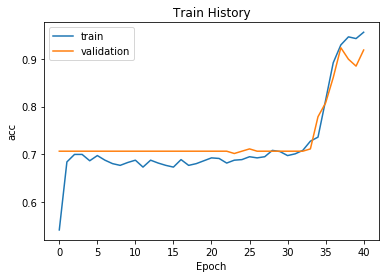

In [48]:
show_train_history(model_history,'acc','val_acc')

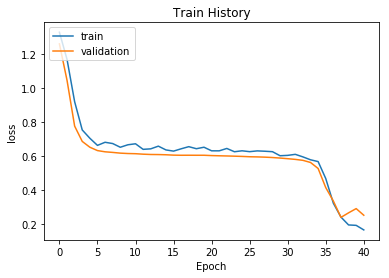

In [49]:
show_train_history(model_history,'loss','val_loss')

In [50]:
# model.save(model_path)


In [51]:
y_predict_name, y_predict, y_predict_probability = predict(model,x_test,mapping)

[0 0 0 0 3 3 0 0 0 0 3 0 3 0 0 0 0 0 3 0 0 3 0 0 0 0 0 0 3 0 0 0 0 0 0 0 3
 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 3 0 0
 3 3 0 0 0 0 3 0 0 0 0 0 3 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 3
 0 3 0 0 0 0 3 0 0 3 0 3 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0
 0 0 0 0 0 0 0 3 0 0 3 3 0 0 0 3 0 0 0 0 0 0 0 0 3 3 0 0 0 3 0 0 0 0 0 0 0
 0 0 0 0 3 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0
 0 0 0 0 3 0 0 0 0 0 0 0 3 3 0 0 0 3 0 0 0 3 0 0 0 0 3 0 0 0 0 0 0 0 3 0 0
 0 3 3 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 3 0 0 3 0 0 0 0 0
 3 0 3 0 0 0 3 0 0 0 0 0 0 3 0 0 0 0 3 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 3 0 0 0 0 0 3 3 0 0 3 0 0 0]
[0 0 0 0 3 3 0 0 0 0 3 0 3 0 0 0 0 0 3 0 0 3 0 0 0 0 0 0 3 0 0 0 0 0 0 0 3
 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 3 0 0
 3 3 0 0 0 0 3 0 0 0 0 0 3 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 3
 0 3 0 0 0 0 3 0 0 3 0 3 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0

In [52]:
model.predict_classes(x_test)

array([0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 3,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 3, 0, 0, 3, 0, 0, 3, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0,
       0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0,
       3, 0, 3, 0, 0, 0, 0, 3, 0, 0, 3, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 0, 0, 3, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0,
       0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 3, 0, 0,
       0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 3, 0, 3,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0,
       0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0,

In [53]:
model.predict(x_test)

array([[9.7625923e-01, 1.6184220e-04, 1.4744602e-04, 2.3431415e-02],
       [9.6202105e-01, 2.1820045e-04, 1.9979918e-04, 3.7560958e-02],
       [9.8093534e-01, 1.3667847e-04, 1.2477492e-04, 1.8803224e-02],
       ...,
       [9.8971611e-01, 7.6696393e-05, 6.9720605e-05, 1.0137489e-02],
       [9.7686279e-01, 1.3774054e-04, 1.2580112e-04, 2.2873661e-02],
       [9.7244102e-01, 1.8506469e-04, 1.6967679e-04, 2.7204322e-02]],
      dtype=float32)

In [54]:
y_predict_name

Index(['BPM平台系統', 'BPM平台系統', 'BPM平台系統', 'BPM平台系統', 'R&D資訊系統', 'R&D資訊系統',
       'BPM平台系統', 'BPM平台系統', 'BPM平台系統', 'BPM平台系統',
       ...
       'BPM平台系統', 'BPM平台系統', 'R&D資訊系統', 'R&D資訊系統', 'BPM平台系統', 'BPM平台系統',
       'R&D資訊系統', 'BPM平台系統', 'BPM平台系統', 'BPM平台系統'],
      dtype='object', length=347)

In [55]:
df_test_y

1128    0
237     0
163     0
739     3
51      0
666     0
818     3
67      0
759     3
553     0
676     0
581     3
1078    0
796     0
435     0
275     0
754     0
605     0
1287    3
358     0
184     0
350     3
1006    0
309     0
900     3
453     0
306     0
76      0
1192    3
810     0
       ..
617     0
610     3
209     3
506     3
140     3
986     3
1093    0
353     0
461     3
199     0
723     3
970     0
365     0
10      0
147     0
522     0
282     0
298     0
528     3
291     0
514     0
914     0
438     3
451     0
665     0
331     3
481     0
1217    0
903     0
458     0
Name: category_a_target, Length: 347, dtype: int64

In [56]:
predict_df = pd.DataFrame({'1_sentence':df_test_x,
              '2_y_predict':y_predict,
              '3_y_predict_name':y_predict_name,
              '4_answer':df_test_y,
              '5_y_predict_probability':list(y_predict_probability)})
predict_df

,1_sentence,2_y_predict,3_y_predict_name,4_answer,5_y_predict_probability
1128,"使用,欲,填寫,申請單,,, ,系統,顯示,查無,資產,編號,,, ,請,協助,處理, ,1...",0,BPM平台系統,0,"[0.97625923, 0.0001618422, 0.00014744602, 0.02..."
237,"無法,順利,簽核,表單, , ,表單,編號,APP0037596, , ,聯絡,分機,382...",0,BPM平台系統,0,"[0.96202105, 0.00021820045, 0.00019979918, 0.0..."
163,"欲,填,快遞,寄件,申請單, ,但連,兩天,出現,錯誤,信息,顯示,錯誤,代碼,500",0,BPM平台系統,0,"[0.98093534, 0.00013667847, 0.00012477492, 0.0..."
739,",開, ,下面,畫面, ,2.5,分鐘,左右, , , , ,leo, ,lin, , ,...",0,BPM平台系統,3,"[0.94353276, 0.00082517526, 0.00074564124, 0.0..."
51,"放行,頁面,Print,鈕,,,無法,下載,PDF,檔,放行",3,R&D資訊系統,0,"[0.11471007, 0.0030284943, 0.0031165492, 0.879..."
666,"BPM,系統,打不開, , ,38514491",3,R&D資訊系統,0,"[0.4148451, 0.0016483525, 0.001584101, 0.5819225]"
818,"project, ,leader,但確,無法,issue,做,assign,reassign...",0,BPM平台系統,3,"[0.9820738, 0.00013129985, 0.00011986027, 0.01..."
67,"請,協助,處理, ,謝謝, , , ,EXT,12633",0,BPM平台系統,0,"[0.98907393, 7.892415e-05, 7.173472e-05, 0.010..."
759,"Download, ,test, ,report, ,出現,Data, ,Failed",0,BPM平台系統,3,"[0.9701746, 0.00016653468, 0.00015203163, 0.02..."
553,"分機, ,15601, , ,問題, ,請假,頁面,無法,使用",0,BPM平台系統,0,"[0.98400843, 0.00010567968, 9.6088384e-05, 0.0..."


In [57]:
# accuracy
accuracy = 1 - (float(len(predict_df[predict_df['2_y_predict'] != predict_df['4_answer']])))/(len(predict_df))
print ('accuracy : {} !!!!!!!!'.format(accuracy))

accuracy : 0.6368876080691643 !!!!!!!!


In [58]:
differ_ans=predict_df[predict_df['2_y_predict'] != predict_df['4_answer']]
differ_ans

,1_sentence,2_y_predict,3_y_predict_name,4_answer,5_y_predict_probability
739,",開, ,下面,畫面, ,2.5,分鐘,左右, , , , ,leo, ,lin, , ,...",0,BPM平台系統,3,"[0.94353276, 0.00082517526, 0.00074564124, 0.0..."
51,"放行,頁面,Print,鈕,,,無法,下載,PDF,檔,放行",3,R&D資訊系統,0,"[0.11471007, 0.0030284943, 0.0031165492, 0.879..."
666,"BPM,系統,打不開, , ,38514491",3,R&D資訊系統,0,"[0.4148451, 0.0016483525, 0.001584101, 0.5819225]"
818,"project, ,leader,但確,無法,issue,做,assign,reassign...",0,BPM平台系統,3,"[0.9820738, 0.00013129985, 0.00011986027, 0.01..."
759,"Download, ,test, ,report, ,出現,Data, ,Failed",0,BPM平台系統,3,"[0.9701746, 0.00016653468, 0.00015203163, 0.02..."
676,"MRO2, ,發,標作業,點,送出,後,發生,異常,目前,人,大陸,連絡,方式,150503...",3,R&D資訊系統,0,"[0.12291189, 0.0033358699, 0.0034260298, 0.870..."
581,"無法,登入, ,PLM, , ,分機,17143",0,BPM平台系統,3,"[0.97060657, 0.0001618141, 0.00014789187, 0.02..."
1078,"無法,操作,零用金,系統, , ,Sorry, ,,, ,Error, ,of, ,Oper...",3,R&D資訊系統,0,"[0.27709636, 0.0111104045, 0.010293473, 0.7014..."
900,"部門,設備,整合,需,將原,NB3,RD1,RD2,設備,整併為,SIT3, , ,驗證,之...",0,BPM平台系統,3,"[0.9851425, 0.0001985595, 0.00017933703, 0.014..."
244,"crate, ,ZAT,ZAY, ,project, ,name, ,點選,Start,出現,錯誤",0,BPM平台系統,3,"[0.98392373, 0.000109382156, 9.9833596e-05, 0...."


In [59]:
pd.DataFrame(differ_ans).to_csv('differ_ans_BPM_RD.csv')

In [60]:
# confusion matrix
pd.crosstab(np.array(y_predict_name), np.array(df_test_y),
            rownames=['predict'], colnames=['answer'])

answer,0,3
predict,,
BPM平台系統,202,87
R&D資訊系統,39,19


In [61]:
# def train(self,epochs=50):
#     print 'building model ...'
#     self.model = SentimentLSTM.build_model()

#     print 'loading data ...'
#     (text_train, rate_train), (text_test, rate_text) = self.load_data()

#     print 'training model ...'
#     self.model.fit(text_train, rate_train,batch_size=1000,epochs=epochs)
#     self.model.save('model/keras.model')
#     score = self.model.evaluate(text_test,rate_text)
#     print score

# def load_trained_model(self,path):
#     model = SentimentLSTM.build_model()
#     model.load_weights(path)
